# 第二次作业

本次作业我们加强对图嵌入模型的实践，具体地，我们需要利用gensim.Word2Vec模型来实现Node2Vec模型。

在开始实践之前，首先请同学回答两个问题：
1. Node2Vec模型中的p参数和q参数各代表什么意思？
2. 在Node2Vec采样随机游走时，如果我们鼓励随机游走访问之前被采样过的节点，我们应该如何调节p或者q？

1. 参数p和q分别代表随机游走时回到前一个节点以及访问离前一个节点距离为2的节点的倾向性，p和q的值越小对应的倾向性越大；

2. 1/p表示访问之前节点的概率(倾向性)，因此鼓励随机游走访问之前被采样过的节点需要增大1/p即减小p。

## 代码填空 - Node2Vec采样随机游走

In [1]:
## install torch-geometric in colab
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-geometric

## update gensim
!pip install -U gensim

Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 10.4 MB 8.3 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 3.7 MB 5.5 MB/s 
     |████████████████████████████████| 308 kB 3.5 MB/s 
     |████████████████████████████████| 379 kB 23.2 MB/s 
     |████████████████████████████████| 45 kB 4.7 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.1-py3-none-any.whl size=513822 sha256=6553413276ffc593e01741dfbb780bb236ee38d7af61470f7beb6b6c1443152e
  Stored in directory: /root/.cache/pip/wheels/78/3d/42/20589db73c66b5109fb93a0c5743edfd6ab5ca820a52afacfc
Successfully built torch-geometric
     |████████████████████████████████| 24.1 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
# 我们导入需要用到的工具包，如果出现ImportError麻烦大家自己安装一下对应的工具包
import numba
import numpy as np
import scipy.sparse as sp
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

In [3]:
def node2vec(adj, embedding_dim=64, walk_length=30, walks_per_node=10,
                  workers=8, window_size=10, num_neg_samples=1, p=4, q=1):
    """
    参数说明
    -------------
    adj : 图的邻接矩阵
    embedding_dim : 图嵌入的维度
    walk_length : 随机游走的长度
    walks_per_node : 每个节点采样多少个随机游走
    workers: word2vec模型使用的线程数量
    window_size: word2vec模型中使用的窗口大小
    num_neg_samples : 负样本的数量
    p: node2vec的p参数
    q: node2vec的q参数
    """
    walks = sample_n2v_random_walks(adj, walk_length, walks_per_node, p=p, q=q) # 利用随机游走提取共现信息
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, vector_size=embedding_dim, 
                     negative=num_neg_samples, compute_loss=True)   # 映射函数、重构器、目标
    embedding = model.wv.vectors[np.fromiter(map(int, model.wv.index_to_key), np.int32).argsort()] # 从词向量中取出节点嵌入
    return embedding

def sample_n2v_random_walks(adj, walk_length, walks_per_node, p, q):
    """
    返回值的类型
    -------
    walks : np.ndarray, shape [num_walks * num_nodes, walk_length]
        采样后的随机游走
    """
    adj = sp.csr_matrix(adj)
    random_walks = _n2v_random_walk(adj.indptr,
                                    adj.indices,
                                    walk_length,
                                    walks_per_node,
                                    p,
                                    q)
    return random_walks 

In [4]:
# 建议debug阶段把下面这行注释掉，debug通过后再把取消下面这行的注释
@numba.jit(nopython=True)
def _n2v_random_walk(indptr,
                    indices,
                    walk_length,
                    walks_per_node,
                    p,
                    q):
    N = len(indptr) - 1 # 节点数量
    final_walks = [] # 存储所有的随机游走
    for _ in range(walks_per_node):
        for n in range(N):
            walk = [n]
            ######################################
            #
            #      同学们需要自己完成这部分代码
            #
            ######################################

            ## random choose a neighbor a the previous node
            prev_node = np.random.choice(indices[indptr[n]: indptr[n+1]])
            curr_node = n

            for _ in range(walk_length-1):
                prev_neighbors = indices[indptr[prev_node]: indptr[prev_node+1]]
                neighbors = indices[indptr[curr_node]: indptr[curr_node+1]]

                prob = np.ones_like(neighbors)/q

                ## update prob
                prob[neighbors == prev_node] = 1/p

                for i in range(len(neighbors)):
                    if np.any(neighbors[i] == prev_neighbors):
                        prob[i] = 1

                ## sample the next node
                prob = prob / prob.sum()
                next_node = random_choice(neighbors, prob)

                ## update
                prev_node = curr_node
                curr_node = next_node

                walk.append(curr_node)

            final_walks.append(walk)
    return np.array(final_walks)

在上面的过程中，大家会需要根据概率来采样数组中的元素，请大家直接使用下面这个`random_choice`函数，它跟`numpy.random.choice`类似，但是这个函数可以支持在numba中使用不同概率来采样。详情可见这个页面<https://github.com/numba/numba/issues/2539#issuecomment-507306369>

In [5]:
@numba.jit(nopython=True)
def random_choice(arr, p):
    """
    参数说明
    ----------
    arr : 1-D 数组
    p : 数组中每个元素对应的概率
    
    返回值
    -------
    samples : 采样后的元素组成的数组
    """
    return arr[np.searchsorted(np.cumsum(p), np.random.random(), side="right")]

## 代码填空- 完成测试代码

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_scipy_sparse_matrix
dataset = Planetoid(root='./data', name='Cora')# 将数据保存在data文件夹下
data = dataset[0]
adj = to_scipy_sparse_matrix(data.edge_index)

Processing...
Done!


In [7]:
embedding = node2vec(adj, embedding_dim=64, p=0.5, q=0.5)
embedding.shape

(2708, 64)

In [8]:
# 请大家完成下面这个测试函数
def evaluate_node_classification(embedding_matrix, labels, train_mask, 
                                 test_mask, normalize_embedding=True, max_iter=1000):
        
    """训练一个线性模型（比如逻辑回归模型）来预测节点的标签
    
    返回值说明
    ----
    preds: 模型预测的标签
    test_acc: 模型预测的准确率
    """
    ######################################
    #
    #      同学们需要自己完成这部分代码
    #
    ######################################   

    ## copy from the sample code
    if normalize_embedding:
        embedding_matrix = normalize(embedding_matrix)

    features_train = embedding_matrix[train_mask]
    features_test = embedding_matrix[test_mask]
    labels_train = labels[train_mask]
    labels_test = labels[test_mask]

    clf = LogisticRegression(solver='lbfgs', max_iter=max_iter, multi_class='auto')
    clf.fit(features_train, labels_train)

    preds = clf.predict(features_test)
    test_acc = accuracy_score(labels_test, preds)
    
    return preds, test_acc

In [9]:
preds, test_acc = evaluate_node_classification(embedding, data.y, data.train_mask, data.test_mask)
print('Test Acc: %.4f' % test_acc)

Test Acc: 0.6810


## 拓展问题

请同学们调节p参数和q参数，对比Node2Vec模型的效果和DeepWalk模型(p=q=1)的效果。

In [10]:
p, q = 1.0, 1.0

embedding = node2vec(adj, embedding_dim=64, p=p, q=q)
preds, test_acc = evaluate_node_classification(embedding, data.y, data.train_mask, data.test_mask)

## baseline
print(f"p = {p:.1f}, q = {q:.1f}, Test Acc: {test_acc:.4f}")

p = 1.0, q = 1.0, Test Acc: 0.6880


In [11]:
metric = np.zeros((20, 20))
candidates = np.linspace(0.1, 2.0, 20)

for i in range(20):
    for j in range(20):
        p = candidates[i]
        q = candidates[j]

        ## train the embedding
        embedding = node2vec(adj, embedding_dim=64, p=p, q=q)

        preds, test_acc = evaluate_node_classification(embedding, data.y, data.train_mask, data.test_mask)

        metric[i, j] = test_acc

        print(f"p = {p:.1f}, q = {q:.1f}, Test Acc: {test_acc:.4f}")

p = 0.1, q = 0.1, Test Acc: 0.6850
p = 0.1, q = 0.2, Test Acc: 0.6720
p = 0.1, q = 0.3, Test Acc: 0.6650
p = 0.1, q = 0.4, Test Acc: 0.6920
p = 0.1, q = 0.5, Test Acc: 0.6490
p = 0.1, q = 0.6, Test Acc: 0.6510
p = 0.1, q = 0.7, Test Acc: 0.6800
p = 0.1, q = 0.8, Test Acc: 0.6120
p = 0.1, q = 0.9, Test Acc: 0.6620
p = 0.1, q = 1.0, Test Acc: 0.6270
p = 0.1, q = 1.1, Test Acc: 0.6590
p = 0.1, q = 1.2, Test Acc: 0.6340
p = 0.1, q = 1.3, Test Acc: 0.6340
p = 0.1, q = 1.4, Test Acc: 0.6540
p = 0.1, q = 1.5, Test Acc: 0.6120
p = 0.1, q = 1.6, Test Acc: 0.6050
p = 0.1, q = 1.7, Test Acc: 0.6260
p = 0.1, q = 1.8, Test Acc: 0.5780
p = 0.1, q = 1.9, Test Acc: 0.5960
p = 0.1, q = 2.0, Test Acc: 0.6140
p = 0.2, q = 0.1, Test Acc: 0.7070
p = 0.2, q = 0.2, Test Acc: 0.6740
p = 0.2, q = 0.3, Test Acc: 0.6880
p = 0.2, q = 0.4, Test Acc: 0.6930
p = 0.2, q = 0.5, Test Acc: 0.6590
p = 0.2, q = 0.6, Test Acc: 0.6470
p = 0.2, q = 0.7, Test Acc: 0.6640
p = 0.2, q = 0.8, Test Acc: 0.6940
p = 0.2, q = 0.9, Te

Text(105.0, 0.5, 'p')

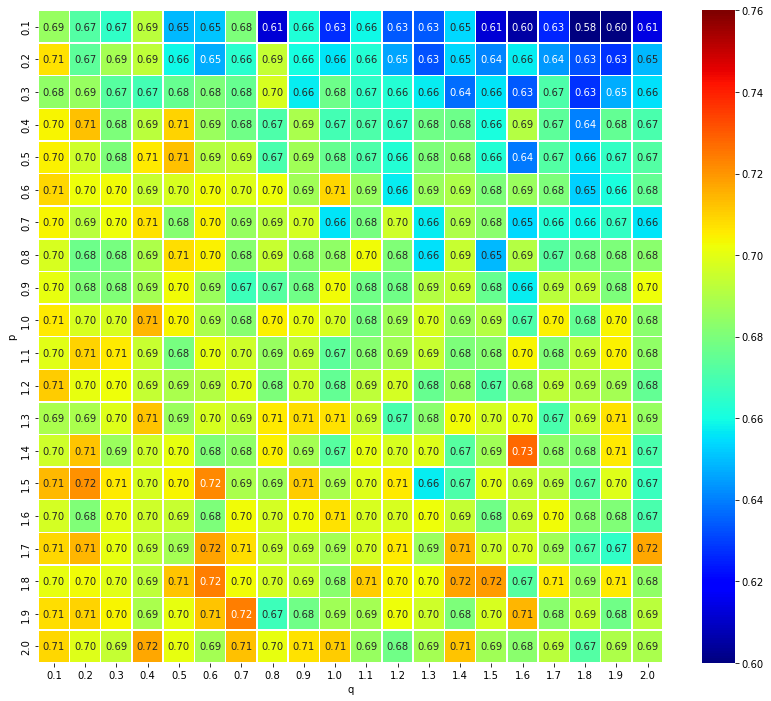

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
         1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

fig = plt.figure(figsize=(14, 12))
ax = sns.heatmap(metric, xticklabels=ticks, yticklabels=ticks, vmin=0.6, vmax=0.76,
                 linewidths=.5, annot=True, fmt=".2f", cmap="jet")
plt.xlabel("q")
plt.ylabel("p")

通过调节p和q的值并用训练词向量得到的准确率作为度量可以得到热力图如上图所示。从整体来看热力图的左下部分要由于右上部分，训练准确率的基准值为0.70（p=q=1.0处对应的准确率）。这说明增大p并减小q有利于提高embedding的效果，即减小随机游走时返回上一节点并鼓励探索未知节点的策略有助于提高embedding的效果，这与我们直观的认知是一致的。